In [1]:
# Please do not change this cell because some hidden tests might depend on it.
import os

# Otter grader does not handle ! commands well, so we define and use our
# own function to execute shell commands.
def shell(commands, warn=True):
    """Executes the string `commands` as a sequence of shell commands.

       Prints the result to stdout and returns the exit status.
       Provides a printed warning on non-zero exit status unless `warn`
       flag is unset.
    """
    file = os.popen(commands)
    print (file.read().rstrip('\n'))
    exit_status = file.close()
    if warn and exit_status != None:
        print(f"Completed with errors. Exit status: {exit_status}\n")
    return exit_status

shell("""
ls requirements.txt >/dev/null 2>&1
if [ ! $? = 0 ]; then
 rm -rf .tmp
 git clone https://github.com/cs236299-2024-winter/project2.git .tmp
 mv .tmp/requirements.txt ./
 rm -rf .tmp
fi
pip install -q -r requirements.txt
""")

In [2]:
# Initialize Otter
import otter
grader = otter.Notebook()

$$
\renewcommand{\vect}[1]{\mathbf{#1}}
\renewcommand{\cnt}[1]{\sharp(#1)}
\renewcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\renewcommand{\softmax}{\operatorname{softmax}}
\renewcommand{\Prob}{\Pr}
\renewcommand{\given}{\,|\,}
$$

# Course 236299
## Project 2: Sequence labeling – The slot filling task

# Introduction

The second segment of the project involves a sequence labeling task, in which the goal is to label the tokens in a text. Many NLP tasks have this general form, for example, _part-of-speech tagging_, which you explored in (optional) lab 2-6. In this project segment, however, you'll use sequence labeling to implement a system for filling the slots in a template that is intended to describe the meaning of an ATIS query. For instance, the sentence

    What's the earliest arriving flight between Boston and Washington DC?
    
might be associated with the following slot-filled template:

    flight_id
        fromloc.cityname: boston
        toloc.cityname: washington
        toloc.state: dc
        flight_mod: earliest arriving
    
You may wonder how this task is a sequence labeling task. We label each word in the source sentence with a tag taken from a set of tags that correspond to the slot-labels. For each slot-label, say `flight_mod`, there are two tags: `B-flight_mod` and `I-flight_mod`. These are used to mark the beginning (B) or interior (I) of a phrase that fills the given slot. In addition, there is a tag for other (O) words that are not used to fill any slot. (This technique is often referred to as IOB encoding.) Thus the sample sentence would be labeled as follows:

| Token   | Label    |
| :------ | :----- |
| `BOS` | `O` |
| `what's` | `O` |
| `the` | `O` |
| `earliest` | `B-flight_mod` |
| `arriving` | `I-flight_mod` |
| `flight` | `O` |
| `between` | `O` |
| `boston` | `B-fromloc.city_name` |
| `and` | `O` |
| `washington` | `B-toloc.city_name` |
| `dc` | `B-toloc.state_code` |
| `EOS` | `O` |

> See below for information about the `BOS` and `EOS` tokens.

The template itself is associated with the question type for the sentence, perhaps as recovered from the sentence as in the last project segment.

In this segment, you'll implement three methods for sequence labeling: two recurrent neural networks (a simple RNN and a long short-term memory network (LSTM)) and (optionally) a hidden markov model (HMM). By the end of this homework, you should have grasped some of the pros and cons of the statistical and neural approaches.

## Goals

1. (Optional, Bonus points) Implement an HMM-based approach to sequence labeling.
2. Implement an RNN-based approach to sequence labeling.
3. Implement an LSTM-based approach to sequence labeling.
4. Compare the performances of the different models with different amounts of training data. Discuss the pros and cons of the each approach.

## Setup

In [3]:
import copy
import math
import matplotlib.pyplot as plt
import random
import csv

import wget
import torch
import torch.nn as nn
import datasets

from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.pre_tokenizers import WhitespaceSplit
from tokenizers.processors import TemplateProcessing
from tokenizers import normalizers
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from transformers import PreTrainedTokenizerFast

from tqdm.auto import tqdm

In [4]:
# Set random seeds
seed = 1234

def reseed(seed=seed):
    random.seed(seed)
    torch.manual_seed(seed)

reseed()

# GPU check, sets runtime type to "GPU" where available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Loading data

We download the ATIS dataset, already presplit into training, validation (dev), and test sets.

In [5]:
# Prepare to download needed data
def download_if_needed(source, dest, filename):
    os.makedirs(data_path, exist_ok=True)  # ensure destination
    if os.path.exists(f"./{dest}{filename}"):
        print(f"Skipping {filename}")
    else:
        print(f"Downloading {filename} from {source}")
        wget.download(source + filename, out=dest)
        print("", flush=True)


source_path = "https://raw.githubusercontent.com/" \
              "nlp-236299/data/master/ATIS/"
data_path = "data/"

# Download files
for filename in ["atis.train.txt", "atis.dev.txt", "atis.test.txt"]:
    download_if_needed(source_path, data_path, filename)

## Data preprocessing

We again use `datasets` and `tokenizers` to load data and convert words to indices in the vocabulary.

We treat words occurring fewer than three times in the training data as _unknown words_. They'll be replaced by the unknown word type `[UNK]`.

In [6]:
for split in ['train', 'dev', 'test']:
    in_file = f'data/atis.{split}.txt'
    out_file = f'data/atis.{split}.csv'

    with open(in_file, 'r') as f_in:
        with open(out_file, 'w') as f_out:
            text, tag = [], []
            writer = csv.writer(f_out)
            writer.writerow(('text','tag'))
            for line in f_in:
                if line.strip() == '':
                    writer.writerow((' '.join(text), ' '.join(tag)))
                    text, tag = [], []
                else:
                    token, label = line.split('\t')
                    text.append(token)
                    tag.append(label.strip())

Let's take a look at what the data files look like.

In [7]:
shell('head -n 3 "data/atis.train.csv"')

text,tag
BOS what is the cost of a round trip flight from pittsburgh to atlanta beginning on april twenty fifth and returning on may sixth EOS,O O O O O O O B-round_trip I-round_trip O O B-fromloc.city_name O B-toloc.city_name O O B-depart_date.month_name B-depart_date.day_number I-depart_date.day_number O O O B-return_date.month_name B-return_date.day_number O
BOS now i need a flight leaving fort worth and arriving in denver no later than 2 pm next monday EOS,O O O O O O O B-fromloc.city_name I-fromloc.city_name O O O B-toloc.city_name B-arrive_time.time_relative I-arrive_time.time_relative I-arrive_time.time_relative B-arrive_time.time I-arrive_time.time B-arrive_date.date_relative B-arrive_date.day_name O


Each is a CSV file where

* The first column contains a string of whitespace-separated tokens, demarcated with beginning of sentence (`BOS`) and end of sentence (`EOS`) tokens; and
* The second column contains the corresponding tags for each of the tokens.

We use Huggingface's `datasets` to prepare the data.

In [8]:
atis = load_dataset(
    "csv",
    data_files={
        "train": "data/atis.train.csv",
        "val": "data/atis.dev.csv",
        "test": "data/atis.test.csv",
    },
)
atis

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tag'],
        num_rows: 4274
    })
    val: Dataset({
        features: ['text', 'tag'],
        num_rows: 572
    })
    test: Dataset({
        features: ['text', 'tag'],
        num_rows: 586
    })
})

In [9]:
train_data = atis['train']
val_data = atis['val']
test_data = atis['test']

train_data.shuffle(seed=seed)

Dataset({
    features: ['text', 'tag'],
    num_rows: 4274
})

We build tokenizers from the training data to tokenize both text and tag and convert them into word ids.

In [10]:
MIN_FREQ = 3
unk_token = "[UNK]"
pad_token = "[PAD]"
bos_token = "<bos>"

def train_tokenizers(dataset, min_freq):
    text_tokenizer = Tokenizer(WordLevel(unk_token=unk_token))
    text_tokenizer.pre_tokenizer = WhitespaceSplit()
    text_tokenizer.normalizer = normalizers.Lowercase()

    text_trainer = WordLevelTrainer(
        min_frequency=min_freq, special_tokens=[pad_token, unk_token, bos_token]
    )
    text_tokenizer.train_from_iterator(dataset["text"], trainer=text_trainer)
    text_tokenizer.post_processor = TemplateProcessing(
        single=f"{bos_token} $A",
        special_tokens=[(bos_token, text_tokenizer.token_to_id(bos_token))],
    )

    tag_tokenizer = Tokenizer(WordLevel(unk_token=unk_token))
    tag_tokenizer.pre_tokenizer = WhitespaceSplit()

    tag_trainer = WordLevelTrainer(special_tokens=[pad_token, unk_token, bos_token])

    tag_tokenizer.train_from_iterator(dataset["tag"], trainer=tag_trainer)

    tag_tokenizer.post_processor = TemplateProcessing(
        single=f"{bos_token} $A",
        special_tokens=[(bos_token, tag_tokenizer.token_to_id(bos_token))],
    )
    return text_tokenizer, tag_tokenizer

text_tokenizer, tag_tokenizer = train_tokenizers(train_data, MIN_FREQ)

We use `datasets.Dataset.map` to convert text into word ids. As shown in lab 1-5, first we need to wrap `tokenizer` with the `transformers.PreTrainedTokenizerFast` class to be compatible with the `datasets` library.

In [11]:
hf_text_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=text_tokenizer,
    pad_token=pad_token,
    unk_token=unk_token,
    bos_token=bos_token,
)

hf_tag_tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tag_tokenizer,
    pad_token=pad_token,
    unk_token=unk_token,
    bos_token=bos_token,
)


def encode(example):
    """Encodes an example by tokenizing the text and converting to ids,
    and similarly for the tags, adding them under appropriate keys
    """
    example["input_ids"] = hf_text_tokenizer(example["text"]).input_ids
    example["tag_ids"] = hf_tag_tokenizer(example["tag"]).input_ids
    return example


# Encode the three datasets into ids
train_data = train_data.map(encode)
val_data = val_data.map(encode)
test_data = test_data.map(encode)

Map:   0%|          | 0/4274 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/586 [00:00<?, ? examples/s]

We can get some sense of the datasets by looking at the sizes of the text and tag vocabularies.

In [12]:
# Extract the text and tag vocabularies
text_vocab = text_tokenizer.get_vocab()
tag_vocab = tag_tokenizer.get_vocab()

# Compute size of vocabularies
vocab_size = len(text_vocab)
num_tags = len(tag_vocab)

print(f"Size of text vocabulary: {vocab_size}")
print(f"Size of tag vocabulary:  {num_tags}")

Size of text vocabulary: 518
Size of tag vocabulary:  104


## Special tokens and tags

You'll have already noticed the `BOS` and `EOS`, special tokens that the dataset developers used to indicate the beginning and end of the sentence; we'll leave them in the data.

We've also prepended `<bos>` for both text and tag. `Tokenizers` will prepend these to the sequence of words and tags. This relieves us from estimating the initial distribution of tags and tokens in HMMs, since we always start with a token `<bos>` whose tag is also `<bos>`. We'll be able to refer to these tags as exemplified here:

In [13]:
print(f"""
Initial tag string: {bos_token}
Initial tag id:     {tag_vocab[bos_token]}
""")


Initial tag string: <bos>
Initial tag id:     2



Finally, since we will be providing the sentences in the training corpus in "batches", we will force the sentences within a batch to be the same length by padding them with a special `[PAD]` token. Again, we can access that token as shown here:|

In [14]:
print(f"""
Pad tag string: {pad_token}
Pad tag id:     {tag_vocab[pad_token]}
""")


Pad tag string: [PAD]
Pad tag id:     0



To load data in batched tensors, we use `torch.utils.data.DataLoader` for data splits, which enables us to iterate over the dataset under a given `BATCH_SIZE`. We use a non-trivial batch size to gain the benefit of training on multiple examples at a shot. You'll need to be careful about the shapes of the various tensors that are being manipulated.

In [15]:
BATCH_SIZE = 32  # batch size

# Defines how to prepare a list of examples to form a batch
def collate_fn(examples):
    batch = {}
    bsz = len(examples)  # no. of examples in the batch, which may be less
    # than BATCH_SIZE in the final batch
    input_ids, tag_ids = [], []
    for example in examples:
        input_ids.append(example["input_ids"])
        tag_ids.append(example["tag_ids"])

    # pad all the examples to be the size of the longest
    max_length = max([len(word_ids) for word_ids in input_ids])
    tag_batch = (
        torch.zeros(bsz, max_length).long().fill_(tag_vocab[pad_token]).to(device)
    )
    text_batch = (
        torch.zeros(bsz, max_length).long().fill_(text_vocab[pad_token]).to(device)
    )
    # tensorize the text and tag sequences
    for b in range(bsz):
        text_batch[b][: len(input_ids[b])] = torch.LongTensor(input_ids[b]).to(device)
        tag_batch[b][: len(tag_ids[b])] = torch.LongTensor(tag_ids[b]).to(device)
    # create the batch
    batch["input_ids"] = text_batch
    batch["tag_ids"] = tag_batch
    return batch


def get_iterators(train_data, val_data, test_data):
    train_iter = torch.utils.data.DataLoader(
        train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
    )
    val_iter = torch.utils.data.DataLoader(
        val_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
    )
    test_iter = torch.utils.data.DataLoader(
        test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn
    )
    return train_iter, val_iter, test_iter


train_iter, val_iter, test_iter = get_iterators(train_data, val_data, test_data)

Now, we can iterate over the dataset. Each batch will be a tensor of size `batch_size x max_length`. Let's examine a batch.

In [16]:
# Get the first batch
batch = next(iter(train_iter))

# What's its shape? Should be batch_size x max_length.
print(f'Shape of batch text tensor: {batch["input_ids"].shape}\n')

# Extract the first sentence in the batch, both text and tags
first_sentence = batch['input_ids'][0]
first_tags = batch['tag_ids'][0]

# Print out the first sentence, as token ids and as text
print("First sentence in batch")
print(f"{first_sentence}")
print(f"{hf_text_tokenizer.decode(first_sentence)}\n")

print("First tags in batch")
print(f"{first_tags}")
print(f"{hf_tag_tokenizer.decode(first_tags)}")

Shape of batch text tensor: torch.Size([32, 21])

First sentence in batch
tensor([  2,   3,  82, 154,   7,  31,  50,  36,  14,  19,  20,  29,   9, 121,
        431,   4,   0,   0,   0,   0,   0], device='cuda:0')
<bos> bos how many flights are there between san francisco and philadelphia on august eighteenth eos [PAD] [PAD] [PAD] [PAD] [PAD]

First tags in batch
tensor([ 2,  3,  3,  3,  3,  3,  3,  3,  5,  8,  3,  4,  3, 13, 12,  3,  0,  0,
         0,  0,  0], device='cuda:0')
<bos> O O O O O O O B-fromloc.city_name I-fromloc.city_name O B-toloc.city_name O B-depart_date.month_name B-depart_date.day_number O [PAD] [PAD] [PAD] [PAD] [PAD]


The goal of this project is thus to predict the sequence of tags `batch['tag_ids']` given a sequence of words `batch['input_ids']`.

# Majority class labeling

As usual, we can get a sense of the difficulty of the task by looking at a simple baseline, tagging every token with the majority tag. Here's a table of tag frequencies for the most frequent tags:

In [17]:
def count_tags(iterator):
    tag_counts = torch.zeros(len(tag_vocab), device=device)

    for batch in iterator:
        tags = batch["tag_ids"].view(-1)
        tag_counts.scatter_add_(0, tags, torch.ones(tags.shape).to(device))

    ## Alternative untensorized implementation for reference
    # for batch in iterator:                # for each batch
    #   for sent_id in range(len(batch)):   # ... each sentence in the batch
    #     for tag in batch.tag[:, sent_id]: # ... each tag in the sentence
    #       tag_counts[tag] += 1            # bump the tag count

    # Ignore paddings
    tag_counts[tag_vocab[pad_token]] = 0
    return tag_counts


tag_counts = count_tags(train_iter)

for tag_id in range(len(tag_vocab)):
    print(f"{tag_id:3}  "
          f"{hf_tag_tokenizer.decode(tag_id):30}"
          f"{tag_counts[tag_id].item():>7.0f}"
    )

  0  [PAD]                               0
  1  [UNK]                               0
  2  <bos>                            4274
  3  O                               38967
  4  B-toloc.city_name                3751
  5  B-fromloc.city_name              3726
  6  I-toloc.city_name                1039
  7  B-depart_date.day_name            835
  8  I-fromloc.city_name               636
  9  B-airline_name                    610
 10  B-depart_time.period_of_day       555
 11  I-airline_name                    374
 12  B-depart_date.day_number          351
 13  B-depart_date.month_name          340
 14  B-depart_time.time                321
 15  B-round_trip                      311
 16  I-round_trip                      303
 17  B-depart_time.time_relative       290
 18  B-cost_relative                   281
 19  B-flight_mod                      264
 20  I-depart_time.time                258
 21  B-stoploc.city_name               202
 22  B-city_name                       191
 23  B-arri

It looks like the `'O'` (other) tag is, unsurprisingly, the most frequent tag (except for the padding tag). The proportion of tokens labeled with that tag (ignoring the padding tag) gives us a good baseline accuracy for this sequence labeling task. To verify that intuition, we can calculate the accuracy of the majority tag on the test set:

In [18]:
tag_counts_test = count_tags(test_iter)
majority_baseline_accuracy = tag_counts_test[tag_vocab["O"]] / tag_counts_test.sum()
print(f"Baseline accuracy: {majority_baseline_accuracy:.3f}")

Baseline accuracy: 0.634


We could try a more sophisticated version of majority class labeling, where we used the majority class tag of each token type, but the gains would not be great. We'll just move on to some more sophisticated methods.

# HMM for sequence labeling (Optional, Bonus points)

Having established the baseline to beat, we turn to implementing an HMM model. **The implementation will be in the HMM class below.** Before getting there, however, we summarize all of the aspects that you'll be implementing in that class.

## Notation

First, let's start with some notation. We use $\mathcal{V} = \langle \mathcal{V}_1, \mathcal{V}_2, \ldots \mathcal{V}_V \rangle$ to denote the vocabulary of word types and $Q = \langle{Q_1, Q_2, \ldots, Q_N} \rangle$ to denote the possible tags, which is the state space of the HMM. Thus $V$ is the number of word types in the vocabulary and $N$ is the number of states (tags).

We use $\vect{w} = w_1 \cdots w_T \in \mathcal{V}^T$ to denote the string of words at "time steps" $t$ (where $t$ varies from $1$ to $T$). Similarly, $\vect{q} = q_1 \cdots q_T \in Q^T$ denotes the corresponding sequence of states (tags).

## Training an HMM by counting

Recall that an HMM is defined via a transition matrix $A$, which stores the probability of moving from one state $Q_i$ to another $Q_j$, that is,

$$A_{ij}=\Prob(q_{t+1}=Q_j  \given  q_t=Q_i)$$

and an emission matrix $B$, which stores the probability of generating word $\mathcal{V}_j$ given state $Q_i$, that is,

$$B_{ij}= \Prob(w_t=\mathcal{V}_j  \given q_t= Q_i)$$

> As is typical in notating probabilities, we'll use abbreviations
>
\begin{align}
\Prob(q_{t+1} \given  q_t) &\equiv \Prob(q_{t+1}=Q_j  \given  q_t=Q_i) \\
\Prob(w_t  \given q_t) &\equiv \Prob(w_t=\mathcal{V}_j  \given q_t= Q_i)
\end{align}
>
> where the $i$ and $j$ are clear from context.

In our case, since the labels are observed in the training data, we can directly use counting to determine (maximum likelihood) estimates of $A$ and $B$.

### Goal 1(a): Find the transition matrix

The matrix $A$ contains the transition probabilities: $A_{ij}$ is the probability of moving from state $Q_i$ to state $Q_j$ in the training data, so that $\sum^{N}_{j = 1 } A_{ij} = 1$ for all $i$.

We find these probabilities by counting the number of times state $Q_j$ appears right after state $Q_i$, as a proportion of all of the transitions from $Q_i$.

$$
A_{ij} = \frac{\cnt{Q_i, Q_j} + \delta}{\sum_k \left (\cnt{Q_i, Q_k}+\delta \right)}
$$

(In the above formula, we also used add-$\delta$ smoothing.)

Using the above definition, **implement the method `train_A` in the `HMM` class below**, which calculates and returns the $A$ matrix as a tensor of size $N \times N$.

> You'll want to go ahead and implement this part now, and test it below, before moving on to the next goal.

> Remember that the training data is being delivered to you batched.

### Goal 1(b): Find the emission matrix $B$

Similar to the transition matrix, the emission matrix contains the emission probabilities such that $B_{ij}$ is probability of word $w_t=\mathcal{V}_j$ conditioned on state $q_t=Q_i$.

We can find this by counting as well.
$$
B_{ij} = \frac{\cnt{Q_i, \mathcal{V}_j} + \delta}{\sum_k \left (\cnt{Q_i, \mathcal{V}_k} + \delta \right)}
       = \frac{\cnt{Q_i, \mathcal{V}_j} + \delta}{\cnt{Q_i} + \delta V}
$$

Using the above definitions, implement the `train_B` method in the `HMM` class below, which calculates and returns the $B$ matrix as a tensor of size $N \times V$.

> You'll want to go ahead and implement this part now, and test it below, before moving on to the next goal.

## Sequence labeling with a trained HMM

Now that you're able to train an HMM by estimating the transition matrix $A$ and the emission matrix $B$, you can apply it to the task of labeling a sequence of words $\vect{w} = w_1 \cdots w_T$. Our goal is to find the most probable sequence of tags $\vect{\hat q} \in Q^T$ given a sequence of words $\vect{w} \in \mathcal{V}^T$.

\begin{align*}
\vect{\hat q} &= \operatorname*{argmax}\limits_{\vect{q} \in Q^T}(\Prob(\vect{q} \given \vect{w})) \\
& = \operatorname*{argmax}_{\vect{q} \in Q^T}(\Prob(\vect{q},\vect{w})) \\
& = \operatorname*{argmax}_{\vect{q} \in Q^T}\left(\Pi^{T}_{t = 1} \Prob(w_{t} \given q_{t})\Prob(q_{t} \given q_{t-1})\right)
\end{align*}

where $\Prob(w_{t}=\mathcal{V}_j \given q_{t}=Q_i) = B_{ij}$, $\Prob(q_{t}=Q_j \given q_{t-1}=Q_{i})=A_{ij}$, and $q_0$ is the predefined initial tag `hf_tag_tokenizer.bos_token_id`.

### Goal 1(c): Viterbi algorithm

Implement the `predict` method, which should use the Viterbi algorithm to find the most likely sequence of tags for a sequence of `words`.

> Warning: It may take up to 30 minutes to tag the entire test set depending on your implementation. (A fully tensorized implementation can be much faster though.) We highly recommend that you begin by experimenting with your code using a _very small subset_ of the dataset, say two or three sentences, ramping up from there.

> Hint: Consider how to use vectorized computations where possible for speed.

## Evaluation

We've provided you with the `evaluate` function, which takes a dataset iterator and uses `predict` on each sentence in each batch, comparing against the gold tags, to determine the accuracy of the model on the test set.

In [19]:
class HMMTagger:
    def __init__(self, hf_text_tokenizer, hf_tag_tokenizer):
        self.hf_text_tokenizer = hf_text_tokenizer  # text tokenizer
        self.hf_tag_tokenizer = hf_tag_tokenizer  # tag tokenizer

        self.V = len(self.hf_text_tokenizer)  # vocabulary size (how many word types)
        self.N = len(self.hf_tag_tokenizer)  # state space size (how many tag type)

        self.initial_state_id = self.hf_tag_tokenizer.bos_token_id  # start with bos
        self.pad_state_id = (
            self.hf_tag_tokenizer.pad_token_id
        )  # pad tokens for text and tags
        self.pad_word_id = self.hf_text_tokenizer.pad_token_id

    def train_A(self, iterator, delta):
        """Returns A for training dataset `iterator` using add-`delta` smoothing."""
        # Create A table to fill in
        A = torch.zeros(self.N, self.N, device=device)

        # TODO: Add your solution from Goal 1(a) here.
        #      The returned value should be a tensor for the A matrix
        #      of size N x N.

        ...

        return A

    def train_B(self, iterator, delta):
        """Returns B for training dataset `iterator` using add-`delta` smoothing."""
        # Create B table to fill in
        B = torch.zeros(self.N, self.V, device=device)

        # TODO: Add your solution from Goal 1 (b) here.
        #      The returned value should be a tensor for the $B$ matrix
        #      of size N x V.

        ...

        return B

    def train_all(self, train_iter, val_iter, delta=0.01):
        """Stores A and B (actually, their logs) for training dataset `train_iter`.
        Ignores `val_iter`, which is provided for for consistency with other
        models."""
        self.log_A = self.train_A(train_iter, delta).log()
        self.log_B = self.train_B(train_iter, delta).log()

    def predict(self, words):
        """Returns the most likely sequence of tags for a sequence of `words`.
        Arguments:
          words: a tensor of size (seq_len,)
        Returns:
          a list of tag ids
        """
        # TODO: Add your solution from Goal 1 (c) here.
        #      The returned value should be a list of tag ids.

        ...

        return bestpath

    def evaluate(self, iterator):
        """Returns the model's token accuracy on a given dataset `iterator`."""
        correct = 0
        total = 0
        for batch in tqdm(iterator, leave=False):
            for sent_id in range(len(batch["input_ids"])):
                words = batch["input_ids"][sent_id]
                words = words[words.ne(self.pad_word_id)]  # remove paddings
                tags_gold = batch["tag_ids"][sent_id]
                tags_pred = self.predict(words)
                for tag_gold, tag_pred in zip(tags_gold, tags_pred):
                    if tag_gold == self.pad_state_id:  # stop once we hit padding
                        break
                    else:
                        total += 1
                        if tag_pred == tag_gold:
                            correct += 1
        return correct / total

Putting everything together, you should now be able to train and evaluate the HMM. A correct implementation can be expected to reach above **90% test set accuracy** after running the following cell.

In [20]:
# Instantiate and train classifier
hmm_tagger = HMMTagger(hf_text_tokenizer, hf_tag_tokenizer)
hmm_tagger.train_all(train_iter, val_iter)

# Evaluate model performance
print(f'Training accuracy: {hmm_tagger.evaluate(train_iter):.3f}\n'
      f'Test accuracy:     {hmm_tagger.evaluate(test_iter):.3f}')

  0%|          | 0/134 [00:00<?, ?it/s]

NameError: name 'bestpath' is not defined

# RNN for Sequence Labeling

Now let's take an alternative (and more trendy) approach: RNN/LSTM-based sequence labeling. You will need to train a model on the training data, and then use the trained model to decode and evaluate some testing data.

<img src="https://github.com/nlp-course/data/raw/master/Resources/rnn-unfolded-figure.png" width=600 align=right />

After unfolding an RNN, the cell at time $t$ generates the observed output $\vect{y}_t$ based on the input $\vect{x}_t$ and the hidden state of the previous cell $\vect{h}_{t-1}$, according to the following equations.

\begin{align*}
\vect{h}_t &=  \sigma(\vect{U} \vect{x}_t + \vect{V} \vect{h}_{t-1}) \\
\vect{\hat y}_t &= \softmax(\vect{W} \vect{h}_t)
\end{align*}

The parameters here are the elements of the matrices $\vect{U}$, $\vect{V}$, and $\vect{W}$. Similar to the last project segment, we will perform the forward computation, calculate the loss, and then perform the backward computation to compute the gradients with respect to these model parameters. Finally, we will adjust the parameters opposite the direction of the gradients to minimize the loss, repeating until convergence.

You've seen these kinds of neural network models before, for language modeling in lab 2-3 and sequence labeling in lab 2-5. The code there should be very helpful in implementing an `RNNTagger` class below. Consequently, we've provided very little guidance on the implementation. We do recommend you follow the steps below however.

## Goal 2(a): RNN training

Implement the forward pass of the RNN tagger and the loss function. A reasonable way to proceed is to implement the following methods:

1. `forward(self, text_batch)`: Performs the RNN forward computation over a whole `text_batch` (`batch.text` in the above data loading example). The `text_batch` will be of shape `max_length x batch_size`. You might run it through the following layers: an embedding layer, which maps each token index to an embedding of size `embedding_size` (so that the size of the mapped batch becomes `max_length x batch_size x embedding_size`); then an RNN, which maps each token embedding to a vector of `hidden_size` (the size of all outputs is `max_length x batch_size x hidden_size`); then a linear layer, which maps each RNN output element to a vector of size $N$ (which is commonly referred to as "logits", recall that $N=|Q|$, the size of the tag set).

This function is expected to return `logits`, which provides a logit for each tag of each word of each sentence in the batch (structured as a tensor of size `max_length x batch_size x N`).

> You might find the following functions useful:
>
> * [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)
> * [`nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
> * [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

2. `compute_loss(self, logits, tags)`: Computes the loss for a batch by comparing `logits` of a batch returned by `forward` to `tags`, which stores the true tag ids for the batch. Thus `logits` is a tensor of size `max_length x batch_size x N`, and `tags` is a tensor of size `max_length x batch_size`. Note that the criterion functions in `torch` expect outputs of a certain shape, so you might need to perform some shape conversions.

> You might find [`nn.CrossEntropyLoss`](https://pytorch.org/docs/master/generated/torch.nn.CrossEntropyLoss.html) from the last project segment useful. Note that if you use `nn.CrossEntropyLoss` then you should not use a softmax layer at the end since that's already absorbed into the loss function. Alternatively, you can use [`nn.LogSoftmax`](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html) as the final sublayer in the forward pass, but then you need to use [`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html), which does not contain its own softmax. We recommend the former, since working in log space is usually more numerically stable.

> Be careful about the shapes/dimensions of tensors. You might find [`torch.Tensor.view`](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) useful for reshaping tensors.

3. `train_all(self, train_iter, val_iter, epochs=10, learning_rate=0.001)`: Trains the model on training data generated by the iterator `train_iter` and validation data `val_iter`.The `epochs` and `learning_rate` variables are the number of epochs (number of times to run through the training data) to run for and the learning rate for the optimizer, respectively. You can use the validation data to determine which model was the best one as the epocks go by. Notice that our code below assumes that during training the best model is stored so that `rnn_tagger.load_state_dict(rnn_tagger.best_model)` restores the parameters of the best model.

## Goal 2(b): RNN decoding

Implement methods to predict the tag sequence associated with a sequence of words and to evaluate a full test dataset:

1. `predict(self, text_batch)`: Returns the batched predicted tag sequences associated with a batch of sentences.
2. `evaluate(self, iterator)`: Returns the accuracy of the trained tagger on a dataset provided by `iterator`.

In [21]:
class RNNTagger(nn.Module):
  def __init__(self, text_tokenizer, tag_tokenizer, embedding_size, hidden_size):
    super().__init__()
    self.text_tokenizer = text_tokenizer
    self.tag_tokenizer = tag_tokenizer
    self.text_vocab = self.text_tokenizer.get_vocab()
    vocab_size = len(self.text_vocab)
    self.tag_vocab = self.tag_tokenizer.get_vocab()
    self.tag_size = len(self.tag_vocab)

    self.embed = torch.nn.Embedding(vocab_size, embedding_size)           # Embedding
    self.rnn = torch.nn.RNN(input_size=embedding_size,
                        hidden_size=hidden_size,
                        num_layers=1,
                        batch_first = True)
    self.hidden2output = torch.nn.Linear(hidden_size, self.tag_size)           # Last layer
    self.criterion = nn.CrossEntropyLoss()
    self.best_model = None

  def forward(self, text_batch):
    '''
    text_batch shape is (batch_size x max_length)
    '''
    batch_size = text_batch.shape[0]
    max_length = text_batch.shape[1]

    embeddings = self.embed(text_batch)   # batch_size x max_length x embedding_size
    output, hidden = self.rnn(embeddings)  # Process whole sequence at once
    logits = self.hidden2output(output)  # batch_size x max_length x tag_size

    return logits

  def compute_loss(self, logits, tags):
    '''
    logits shape is (batch_size x max_length x tag_size)
    tags shape is (batch_size x max_length)
    '''
    # Reshape logits to (batch_size * max_length, tag_size)
    logits = logits.reshape(-1, self.tag_size)
    # Reshape tags to (batch_size * max_length)
    tags = tags.reshape(-1)

    loss = self.criterion(logits, tags)
    return loss

  def train_all(self, train_iter, val_iter, epochs=10, learning_rate=0.001):
    self.train()

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    for i in range(epochs):
      self.train()
      train_epoch_losses = []
      for batch in train_iter:
        input_ids = batch['input_ids']
        tag_ids = batch['tag_ids']

        optimizer.zero_grad()
        logits = self.forward(input_ids)
        loss = self.compute_loss(logits, tag_ids)
        train_epoch_losses.append(loss)
        loss.backward()
        optimizer.step()

      self.eval()
      val_epoch_losses = []
      for batch in val_iter:
        input_ids = batch['input_ids']
        tag_ids = batch['tag_ids']

        logits = self.forward(input_ids)
        loss = self.compute_loss(logits, tag_ids)
        val_epoch_losses.append(loss)

      curr_val_loss = sum(val_epoch_losses) / float(len(val_epoch_losses))
      val_losses.append(curr_val_loss)
      train_losses.append(sum(train_epoch_losses) / float(len(train_epoch_losses)))

      if curr_val_loss < best_val_loss:
        best_val_loss = curr_val_loss
        self.best_model = self.state_dict()

  def predict(self, text_batch):
    logits = self.forward(text_batch)
    # logits shape: (batch_size x max_length x N)
    preds = torch.argmax(logits, dim=2)
    return preds

  def evaluate(self, iterator):
    correct_count = 0
    total_count = 0
    for batch in iterator:
      input_ids = batch['input_ids']
      tag_ids = batch['tag_ids']

      preds = self.predict(input_ids)
      # preds shape is (batch_size x max_length)
      pad_id = 0
      non_pad_mask = tag_ids != pad_id
      matches = (preds == tag_ids) & non_pad_mask
      total_count += non_pad_mask.sum().item()
      correct_count += matches.sum().item()

    return correct_count / total_count

Now train your tagger on the training and validation set.
Run the cell below to train an RNN, and evaluate it. A proper implementation should reach about **95%+ accuracy**.

In [22]:
# Instantiate and train classifier
rnn_tagger = RNNTagger(hf_text_tokenizer,
                       hf_tag_tokenizer,
                       embedding_size=36,
                       hidden_size=36).to(device)
rnn_tagger.train_all(train_iter, val_iter, epochs=10, learning_rate=0.001)
rnn_tagger.load_state_dict(rnn_tagger.best_model)

# Evaluate model performance
print(f'Training accuracy: {rnn_tagger.evaluate(train_iter):.3f}\n'
      f'Test accuracy:     {rnn_tagger.evaluate(test_iter):.3f}')

Training accuracy: 0.958
Test accuracy:     0.951


RNNs tend to exhibit the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). To remedy this, the Long-Short Term Memory (LSTM) model was introduced. In PyTorch, we can simply use [`nn.LSTM`](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

# Goal 3: Implement an LSTM model

In this section, you'll implement an LSTM model for slot filling. If you've got the RNN model well implemented, this should be extremely straightforward. Just copy and paste your solution, change the call to `nn.RNN` to a call to `nn.LSTM`, and make any other minor adjustments that are necessary. In particular, LSTMs have _two_ recurrent parts, `h` and `c`. You'll thus need to initialize both of these when performing forward computations.

In [23]:
class LSTMTagger(nn.Module):
  def __init__(self, text_tokenizer, tag_tokenizer, embedding_size, hidden_size):
    super().__init__()
    self.text_tokenizer = text_tokenizer
    self.tag_tokenizer = tag_tokenizer
    self.text_vocab = self.text_tokenizer.get_vocab()
    vocab_size = len(self.text_vocab)
    self.tag_vocab = self.tag_tokenizer.get_vocab()
    self.tag_size = len(self.tag_vocab)
    self.hidden_size = hidden_size

    self.embed = torch.nn.Embedding(vocab_size, embedding_size)           # Embedding
    self.lstm = torch.nn.LSTM(input_size=embedding_size,
                        hidden_size=hidden_size,
                        num_layers=1,
                        batch_first = True)
    self.hidden2output = torch.nn.Linear(hidden_size, self.tag_size)           # Last layer
    self.criterion = nn.CrossEntropyLoss()
    self.best_model = None

  def forward(self, text_batch):
    '''
    text_batch shape is (batch_size x max_length)
    '''
    batch_size = text_batch.shape[0]
    max_length = text_batch.shape[1]

    # hidden = torch.zeros(1, batch_size, self.hidden_size).to(device)
    # cell = torch.zeros(1, batch_size, self.hidden_size).to(device)
    hidden = torch.randn(1, batch_size, self.hidden_size).to(device) * 0.1
    cell = torch.randn(1, batch_size, self.hidden_size).to(device) * 0.1

    embeddings = self.embed(text_batch)   # batch_size x max_length x embedding_size
    output, (hidden, cell) = self.lstm(embeddings, (hidden, cell))
    logits = self.hidden2output(output)  # batch_size x max_length x tag_size

    return logits

  def compute_loss(self, logits, tags):
    '''
    logits shape is (batch_size x max_length x tag_size)
    tags shape is (batch_size x max_length)
    '''
    # Reshape logits to (batch_size * max_length, tag_size)
    logits = logits.reshape(-1, self.tag_size)
    # Reshape tags to (batch_size * max_length)
    tags = tags.reshape(-1)

    loss = self.criterion(logits, tags)
    return loss

  def train_all(self, train_iter, val_iter, epochs=10, learning_rate=0.001):
    self.train()

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    for i in range(epochs):
      self.train()
      train_epoch_losses = []
      for batch in train_iter:
        input_ids = batch['input_ids']
        tag_ids = batch['tag_ids']

        optimizer.zero_grad()
        logits = self.forward(input_ids)
        loss = self.compute_loss(logits, tag_ids)
        train_epoch_losses.append(loss)
        loss.backward()
        optimizer.step()

      self.eval()
      val_epoch_losses = []
      for batch in val_iter:
        input_ids = batch['input_ids']
        tag_ids = batch['tag_ids']

        logits = self.forward(input_ids)
        loss = self.compute_loss(logits, tag_ids)
        val_epoch_losses.append(loss)

      curr_val_loss = sum(val_epoch_losses) / float(len(val_epoch_losses))
      val_losses.append(curr_val_loss)
      train_losses.append(sum(train_epoch_losses) / float(len(train_epoch_losses)))

      if curr_val_loss < best_val_loss:
        best_val_loss = curr_val_loss
        self.best_model = self.state_dict()

  def predict(self, text_batch):
    logits = self.forward(text_batch)
    # logits shape: (batch_size x max_length x N)
    preds = torch.argmax(logits, dim=2)
    return preds

  def evaluate(self, iterator):
    correct_count = 0
    total_count = 0
    for batch in iterator:
      input_ids = batch['input_ids']
      tag_ids = batch['tag_ids']

      preds = self.predict(input_ids)
      # preds shape is (batch_size x max_length)
      pad_id = 0
      non_pad_mask = tag_ids != pad_id
      matches = (preds == tag_ids) & non_pad_mask
      total_count += non_pad_mask.sum().item()
      correct_count += matches.sum().item()

    return correct_count / total_count

Run the cell below to train an LSTM, and evaluate it. A proper implementation should reach about **95%+ accuracy**.

In [24]:
# Instantiate and train classifier
lstm_tagger = LSTMTagger(hf_text_tokenizer,
                         hf_tag_tokenizer,
                         embedding_size=36,
                         hidden_size=36).to(device)
lstm_tagger.train_all(train_iter, val_iter, epochs=10, learning_rate=0.001)
lstm_tagger.load_state_dict(lstm_tagger.best_model)

# Evaluate model performance
print(f'Training accuracy: {lstm_tagger.evaluate(train_iter):.3f}\n'
      f'Test accuracy:     {lstm_tagger.evaluate(test_iter):.3f}')

Training accuracy: 0.954
Test accuracy:     0.946


# Goal 4: Compare the various models with different amounts of training data

Vary the amount of training data and compare the performance of RNN to LSTM to HMM (if you implemented it). Discuss the pros and cons of the models based on your experiments.

> This part is more open-ended. We're looking for thoughtful experiments and analysis of the results, not any particular result or conclusion. In addition to experimenting with different amounts of training data, you might want to vary other aspects of the models. We recommend you structure your code with useful abstractions to simplify the experimentation and reporting of results.

The code below shows how to subsample the training set with downsampling ratio `ratio`. To speed up evaluation we only use 50 test samples.

In [25]:
# Thoughtful Experiments:
# 1. Different training sets sizes
# 2. Different hidden dimensions
# 3. Different learning rates

In [26]:
def create_iterators(ratio=0.1):
  test_size = 50

  # Set random seeds to make sure subsampling is the same for all models
  reseed()

  atis = load_dataset('csv', data_files={'train':'data/atis.train.csv', \
                                        'val': 'data/atis.dev.csv', \
                                        'test': 'data/atis.test.csv'})
  train_data = atis['train']
  test_data = atis['test']
  val_data = atis['val']

  # Subsample
  train_data = train_data.shuffle(seed=seed)
  train_data = train_data.select(list(range(len(train_data)))[:int(math.floor(len(train_data)*ratio))])
  test_data = test_data.shuffle(seed=seed)
  test_data = test_data.select(list(range(len(test_data)))[:test_size])
  val_data = val_data.shuffle(seed=seed)
  val_data = val_data.select(list(range(len(val_data)))[:int(math.floor(len(val_data)))])

  # Rebuild vocabulary
  text_tokenizer, tag_tokenizer = train_tokenizers(train_data, MIN_FREQ)

  # Encode data
  hf_text_tokenizer = PreTrainedTokenizerFast(tokenizer_object=text_tokenizer, pad_token=pad_token, unk_token=unk_token, bos_token=bos_token)

  hf_tag_tokenizer = PreTrainedTokenizerFast(tokenizer_object=tag_tokenizer, pad_token=pad_token, unk_token=unk_token, bos_token=bos_token)

  def encode(example):
      example['input_ids'] = hf_text_tokenizer(example['text']).input_ids
      example['tag_ids'] = hf_tag_tokenizer(example['tag']).input_ids
      return example

  train_data = train_data.map(encode)
  val_data = val_data.map(encode)
  test_data = test_data.map(encode)

  # Create iterators
  train_iter, val_iter, test_iter = get_iterators(train_data, val_data, test_data)
  return train_iter, val_iter, test_iter

In [27]:
def compare_models(ratios, lrs, hidden_dims):
  rnn_accs = {}
  lstm_accs = {}
  for ratio in ratios:
    train_iter, val_iter, test_iter = create_iterators(ratio)
    for lr in lrs:
      for hidden_dim in hidden_dims:
        rnn_model = RNNTagger(hf_text_tokenizer,
                       hf_tag_tokenizer,
                       embedding_size=hidden_dim,
                       hidden_size=hidden_dim).to(device)
        lstm_model = LSTMTagger(hf_text_tokenizer,
                         hf_tag_tokenizer,
                         embedding_size=hidden_dim,
                         hidden_size=hidden_dim).to(device)
        rnn_model.train_all(train_iter, val_iter, epochs=10, learning_rate=lr)
        lstm_model.train_all(train_iter, val_iter, epochs=10, learning_rate=lr)
        rnn_model.load_state_dict(rnn_model.best_model)
        lstm_model.load_state_dict(lstm_model.best_model)

        if (lr, hidden_dim) not in rnn_accs:
          rnn_accs[(lr, hidden_dim)] = [rnn_model.evaluate(test_iter)]
          lstm_accs[(lr, hidden_dim)] = [lstm_model.evaluate(test_iter)]
        else:
          rnn_accs[(lr, hidden_dim)].append(rnn_model.evaluate(test_iter))
          lstm_accs[(lr, hidden_dim)].append(lstm_model.evaluate(test_iter))

  return rnn_accs, lstm_accs

In [28]:
ratios = [0.1, 0.4, 0.7, 1]
lrs = [0.1, 0.01, 0.001]
hidden_dims = [36, 72, 108]
rnn_accs, lstm_accs = compare_models(ratios, lrs, hidden_dims)
print(rnn_accs)
print(lstm_accs)

Map:   0%|          | 0/427 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/1709 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/2991 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/4274 [00:00<?, ? examples/s]

Map:   0%|          | 0/572 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

{(0.1, 36): [0.9261285909712722, 0.957592339261286, 0.9521203830369357, 0.960328317373461], (0.1, 72): [0.9316005471956225, 0.9357045143638851, 0.9233926128590971, 0.9288645690834473], (0.1, 108): [0.9069767441860465, 0.9343365253077975, 0.9302325581395349, 0.9425444596443229], (0.01, 36): [0.9534883720930233, 0.9726402188782489, 0.9890560875512996, 0.9890560875512996], (0.01, 72): [0.960328317373461, 0.9822161422708618, 0.9835841313269493, 0.9890560875512996], (0.01, 108): [0.9671682626538988, 0.9726402188782489, 0.9835841313269493, 0.9753761969904241], (0.001, 36): [0.7496580027359782, 0.9097127222982216, 0.9616963064295485, 0.9726402188782489], (0.001, 72): [0.8467852257181943, 0.9644322845417237, 0.9794801641586868, 0.9822161422708618], (0.001, 108): [0.8919288645690835, 0.9753761969904241, 0.9849521203830369, 0.9890560875512996]}
{(0.1, 36): [0.9630642954856361, 0.9671682626538988, 0.9616963064295485, 0.9644322845417237], (0.1, 72): [0.9521203830369357, 0.9589603283173734, 0.96032

In [29]:
import matplotlib.pyplot as plt

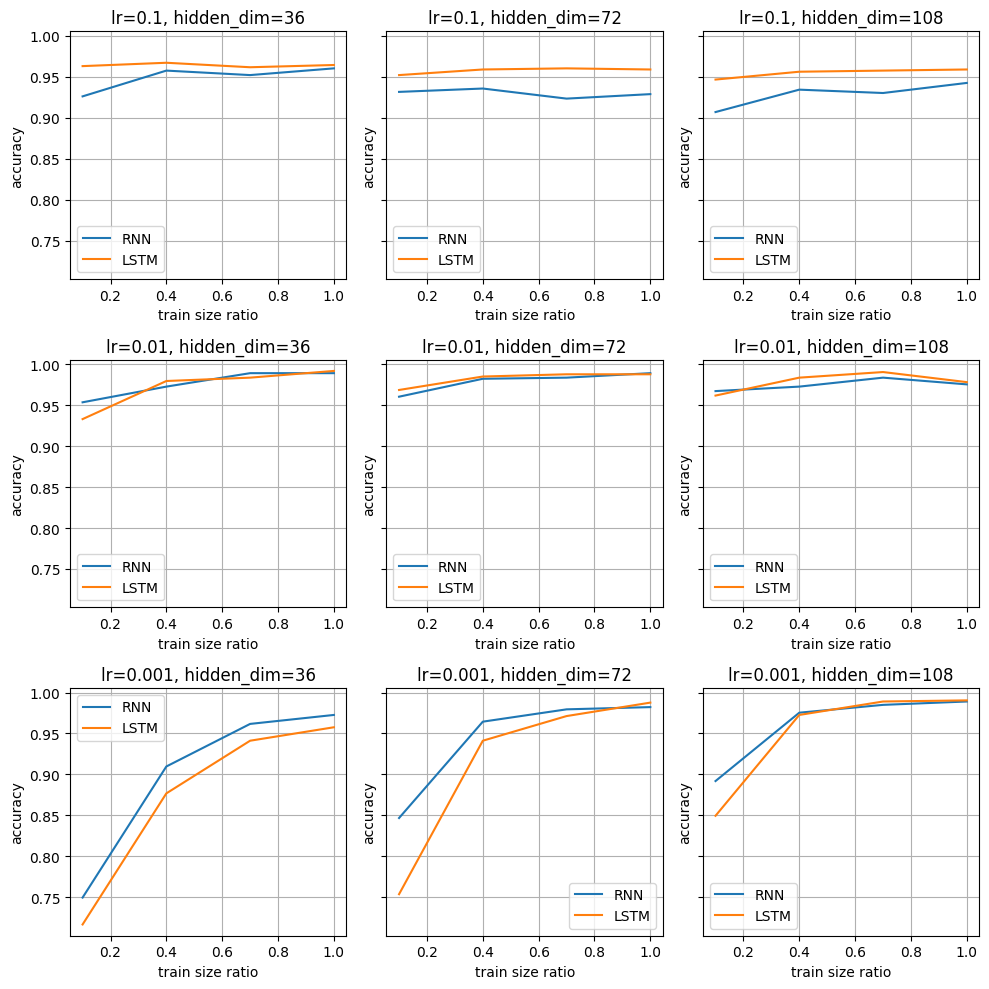

In [30]:
fig, axs = plt.subplots(nrows=len(lrs), ncols=len(hidden_dims), figsize=(10, 10), sharey='all')
for l, lr in enumerate(lrs):
  for h, hidden_dim in enumerate(hidden_dims):
    axs[l, h].plot(ratios, rnn_accs[(lr, hidden_dim)], label='RNN')
    axs[l, h].plot(ratios, lstm_accs[(lr, hidden_dim)], label='LSTM')
    axs[l, h].set_title(f'lr={lr}, hidden_dim={hidden_dim}')
    axs[l, h].set_xlabel('train size ratio')
    axs[l, h].set_ylabel('accuracy')
    axs[l, h].grid()
    axs[l, h].legend()
fig.tight_layout()
plt.show()

We conducted experiments with three factors, comparing the test accuracies of LSTM and RNN models across different training set sizes (using different ratios), learning rates (LRs), and hidden dimensions. There are numerous conclusions to draw from these plots, so we will first focus on the differences between the models and later discuss common trends observed in both.

**The main difference lies in the effect of the training set size on the accuracies.** Although both models benefit from larger training sets, the LSTM model seems to gain even more as the ratio increases. In many graphs (especially for LR = 0.001), the RNN model outperforms the LSTM at lower ratios. However, as the ratio grows, the LSTM model surpasses the RNN, or achieves comparable results. One possible explanation for this phenomenon is the increased complexity of the LSTM model, requires larger datasets to fully leverage its learning potential.

**Common Trends:**
1. For both models, we found that LR = 0.01 improved accuracies, while both smaller lr values (0.001, which is the default in this project) and larger lr values (0.1) resulted in poorer performance.
2. Interestingly, as the learning rates increase, the effect of the training set size on accuracies becomes weaker. We have two explanations for this observation:
* We assume that higher learning rates enable the model to learn more effectively from a given dataset, reducing the need for larger datasets. This trend is evident in the graphs, where the slope is steeper for smaller learning rates.
* For large learning rates, the model might oscilate around minima points, meaning that more training data might not help the model to converge, since the model may just continue oscilating.
3. Weak effect of the hidden dimensions on both models:
We observe that for each learning rate, the models approximately converge to the same accuracy across different hidden dimensions. The main impact of hidden dimensions was seen for lr=0.001 and small ratio (0.2), where there is a noticeable difference in the starting point of each graph. This observation was counter-intuitive for us, because using a large hidden dimension means that there many weights for the model to learn. Therefore, we expected that models with a large hidden dimension would benefit more from large training sets rather than small training sets.

<!-- BEGIN QUESTION -->

# Prompting Modern Large Language Models (LLMs)

**Question:** Modern large-scale language models (such as Claude, ChatGPT, Gemini, Llama) have various capabilities, that can be shown by prompting them correctly (i.e. giving them a correct input prompt). For example, they can even be useful for solving text classification, discussed in this segment. Try to see if you can prompt an LLM (of your choosing) to solve the task of sequence labeling on some of the examples of data samples seen in this segment. Write a short paragraph about your experience - what worked better, what worked worse. Note that your not expected to devise a fool-proof prompting method, but only to qualitatively experiment with prompting.

<!--
BEGIN QUESTION
name: lm_experimentation
manual: true
-->

We experimented with different LLMs, trying to test which one does best at the classification task of slot filling. We first created a detailed prompt explaining the task, presenting the possible labels and 4 examples for setences and their part of speech tagging as our "training data".

We passed the same prompt as input to 3 LLMs: Claude Sonnet 3.5, Chat GPT 4o and Gemini 2.0 Flash Experimental. Then, we tested the three models with 3 test examples and compared the results.

Accuracy results from the 3 test examlpes (number of tokens classified correctly):

* Claude Sonnet 3.5:              87.76% (43 out of 49)
* Chat GPT 4o:                    65.31% (32 out of 49)
* Gemini 2.0 Flash Experimental:  83.67% (41 out of 49)

We see that Claude and Gemini did well in this task, while Chat GPT achieved rather poor results.

Interesting points we saw during the experiment:
1. For the first test example, Gemini quoted some source from GitHub in the response. This probably means that it spotted in the source the exact label sequence. This suggests that our test examples might have already been seen by Gemini, strongly hinting at a data leakage. This might also explain the high accuracy it showed and raises questions whether Claude has the same type of advantage, as it showed even better results.
2. Chat GPT 4o was the only LLM to output a wrong number of labels (for the first example), which caused its success rate to drop significantly.

Extra information about the experiment is presented in the cell below.

### Extra Info about the experiment

The "training prompt" was also created with the assistance of an LLM, in this case we used Claude 3.5 Sonnet. Below is an outline of the prompt we used to generate the "training prompt":

Write a prompt teaching an LLM the classification task and making it perform classifications entered inputs. Make sure to include all relevant information about the task and create a clear format to enter training examples with their true labels, as well as testing the LLM on unseen examples. <*more info about the task*>

Also add the possible label list: <*Label List*>

And use these examples and labels as the training data to ‘train’ the LLM: <*Training Data*>. We chose to omit the Padding token from the training data, as we don’t use batches, just feeding training data into the LLM.

The training prompt we used:
# ATIS Slot Filling Task Instructions

You are a sequence labeling system specialized in the ATIS (Airline Travel Information System) slot filling task. Your goal is to label each token in flight-related queries with appropriate slot tags using the IOB (Inside-Outside-Beginning) format.

## Task Description
For each word in an input sentence, you must assign one of the valid slot labels listed below. The labeling follows the IOB (Inside-Outside-Beginning) format:
- B-[slot_name]: Marks the Beginning of a phrase filling a specific slot
- I-[slot_name]: Marks the Inside/continuation of a phrase filling a specific slot
- O: Marks words that don't fill any slot (Outside)

## Special Tokens
- <bos>: Beginning of sentence marker (tag: <bos>)
- [PAD]: Padding token (tag: [PAD])
- [UNK]: Unknown token (tag: O)

## Complete Label Set
Most frequent to least frequent (showing count of occurrences in training data):

1. Core Location Tags:
- B-toloc.city_name (3751)
- B-fromloc.city_name (3726)
- I-toloc.city_name (1039)
- I-fromloc.city_name (636)
- B-stoploc.city_name (202)
- B-city_name (191)

2. Date and Time Tags:
- B-depart_date.day_name (835)
- B-depart_time.period_of_day (555)
- B-depart_date.day_number (351)
- B-depart_date.month_name (340)
- B-depart_time.time (321)
- B-depart_time.time_relative (290)
- B-arrive_time.time (182)
- B-arrive_time.time_relative (162)
- I-arrive_time.time (142)

3. Airline and Flight Tags:
- B-airline_name (610)
- I-airline_name (374)
- B-round_trip (311)
- I-round_trip (303)
- B-flight_mod (264)
- B-flight_stop (141)
- B-airline_code (109)
- B-flight_number (72)

4. Additional Location Qualifiers:
- B-toloc.state_name (84)
- B-toloc.state_code (81)
- B-fromloc.airport_name (75)
- B-fromloc.state_code (51)
- B-airport_name (44)
- B-toloc.airport_name (28)

5. Other Common Tags:
- B-cost_relative (281)
- B-class_type (181)
- I-class_type (148)
- B-fare_basis_code (51)
- B-flight_time (51)
- B-meal_description (48)
- B-transport_type (43)

## Training Examples
Format:
Input: <sentence>
Labels: [corresponding tags]

Example 1:

Input: <bos> bos how many flights are there between san francisco and philadelphia on august eighteenth eos

Labels: <bos> O O O O O O O B-fromloc.city_name I-fromloc.city_name O B-toloc.city_name O B-depart_date.month_name B-depart_date.day_number O

Example 2:

Input: <bos> bos please list all flights from philadelphia to boston eos

Labels: <bos> O O O O O O B-fromloc.city_name O B-toloc.city_name O

Example 3:

Input: <bos> bos is there a flight on american airlines going from boston to san francisco on june twenty eighth eos

Labels: <bos> O O O O O O B-airline_name I-airline_name O O B-fromloc.city_name O B-toloc.city_name I-toloc.city_name O B-depart_date.month_name B-depart_date.day_number I-depart_date.day_number O

Example 4:

Input: <bos> bos what type of aircraft leaves from boston to washington dc at 9 am eos

Labels: <bos> O O O O O O O B-fromloc.city_name O B-toloc.city_name B-toloc.state_code O B-depart_time.time I-depart_time.time O

## Key Labeling Rules
1. Always start with <bos> tag
2. Use B- prefix for the first token of any entity
3. Use I- prefix for continuation tokens of the same entity
4. Use O for words that don't fill any slot
5. Pay special attention to:
   - Multi-word city names (e.g., "San Francisco" → B-fromloc.city_name I-fromloc.city_name)
   - Time expressions (e.g., "9 am" → B-depart_time.time I-depart_time.time)
   - Airline names (e.g., "American Airlines" → B-airline_name I-airline_name)
   - Date expressions (e.g., "twenty eighth" → B-depart_date.day_number I-depart_date.day_number)

## Your Task
When given a new input sentence:
1. Analyze the full sentence to understand the context
2. Assign appropriate IOB tags to each token based on its role
3. Ensure consistent use of B- and I- prefixes for multi-token entities
4. Output the labels in the same format as the training examples

Now you can begin labeling new queries using this standardized format and comprehensive label set.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

# Debrief

**Question:** We're interested in any thoughts you have about this project segment so that we can improve it for later years, and to inform later segments for this year. Please list any issues that arose or comments you have to improve the project segment. Useful things to comment on include the following, but you are not restricted to these:

* Was the project segment clear or unclear? Which portions?
* Were the readings appropriate background for the project segment?
* Are there additions or changes you think would make the project segment better?

<!--
BEGIN QUESTION
name: open_response_debrief
manual: true
-->

_Type your answer here, replacing this text._

<!-- END QUESTION -->



# Instructions for submission of the project segment

This project segment should be submitted to Gradescope, which will be made available some time before the due date.

Project segment notebooks are manually graded, not autograded using otter as labs are. (Otter is used within project segment notebooks to synchronize distribution and solution code however.) **We will not run your notebook before grading it.** Instead, we ask that you **submit the already freshly run notebook**. The best method is to "restart kernel and run all cells", allowing time for all cells to be run to completion. You should submit your code to Gradescope at the code submission assignment at <https://www.gradescope.com/courses/903849?submit_assignment_id=5229511>.

We also request that you **submit a PDF of the freshly run notebook**. The simplest method is to use "Export notebook to PDF", which will render the notebook to PDF via LaTeX. If that doesn't work, the method that seems to be most reliable is to export the notebook as HTML (if you are using Jupyter Notebook, you can do so using `File -> Print Preview`), open the HTML in a browser, and print it to a file. Then make sure to add the file to your git commit. Please name the file the same name as this notebook, but with a `.pdf` extension. (Conveniently, the methods just described will use that name by default.) You can then perform a git commit and push and submit the commit to Gradescope at <https://www.gradescope.com/courses/903849?submit_assignment_id=5229512>.

# End of project segment 2 {-}